# Bert Training with Early Stopping

## 0. Setup

### 0.1 Install libraries

In [57]:
! pip install -r requirements.txt

# If you work with GPU-support (CUDA 12.8):
! pip install torch==2.7.1+cu128 -f https://download.pytorch.org/whl/torch/
! pip install torchaudio==2.7.1+cu128 -f https://download.pytorch.org/whl/torchaudio/
! pip install torchvision==0.22.1+cu128 -f https://download.pytorch.org/whl/torchvision/

# If you only work with CPU-support:
# ! pip install torch==2.7.1
# ! pip install torchaudio==2.7.1
# ! pip install torchvision==0.22.1


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torch/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchaudio/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://download.pytorch.org/whl/torchvision/



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.2 GPU setup

In [58]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 2070 with Max-Q Design


## 1 Configuration

In [59]:
# Data variables
data_path = "../../data/training_data/labeled/labeled_data.xlsx" # path to the Excel file with the labeled data
results_path = "../../data/model_performance" # path to where the results should be stored
text_column_name = "expanded" # name of the column containing the text to classify
label_column_name = "label" # name of the column containing the labels (0 = correct or 1 = incorrect)
num_labels = 2 # binary classification (see above)

# Model configuration
model_name = "bert-base-uncased" # standard BERT; "allenai/scibert_scivocab_uncased" for SciBERT and "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract" for PubMedBERT
test_size = 0.2 # ratio of the dataset to be used for testing
validation_size = 0.1 # ration of the training set (80%) to be used for validation (model evaluation after each epoch)
max_length = 256 # maximum length of the input sequences for BERT
num_epochs = 10 # number of epochs for training
batch_size = 32 # batch size for training and evaluation
learning_rate = 2e-5 # learning rate for the optimizer
weight_decay = 0.01 # weight decay for the optimizer
early_stopping_patience = 2 # number of epochs with no improvement after which training will be stopped

# Seed for reproducibility
import random
import numpy as np
from transformers import set_seed
import os

seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
set_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2 Read and prepare dataset

In [60]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA
df = df[df['label'].notna()]

# Remove rows where 'label' is -99
df = df[df['label'] != -99]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance labels via undersampling (generalized)
label_counts = df['label'].value_counts()  # Get counts of each label
minority_label = label_counts.idxmin() # Get the minority label
majority_label = label_counts.idxmax() # Get the majority label

df_minority = df[df['label'] == minority_label]
df_majority = df[df['label'] == majority_label]

df_majority_downsampled = resample( # Downsample majority label
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=seed
)

df = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=seed).reset_index(drop=True)

# Check label balance in data
print("Training label distribution:")
print(df['label'].value_counts())

Training label distribution:
label
0    355
1    355
Name: count, dtype: int64


### 2.1 Create train & validation set and test set

In [61]:
from sklearn.model_selection import train_test_split

# Put 20 % of the data into a test set, for evaluation at the end
train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=seed)

# Put 10 % of the training data into a test set, for evaluation at the end
train_df, validation_df = train_test_split(train_df, test_size=validation_size, stratify=train_df['label'], random_state=seed)

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)

#### 2.1.1 Label balance in all three datasets

In [62]:
# training set
print("Training label distribution:")
print(train_df['label'].value_counts())

# validation set
print("Validation label distribution:")
print(validation_df['label'].value_counts())

# test set
print("Test label distribution:")
print(test_df['label'].value_counts())

Training label distribution:
label
1    256
0    255
Name: count, dtype: int64
Validation label distribution:
label
0    29
1    28
Name: count, dtype: int64
Test label distribution:
label
1    71
0    71
Name: count, dtype: int64


### 2.2 Tokenize 'text'

In [63]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_for_bert(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=max_length)

tokenized_train = train_dataset.map(tokenize_for_bert, batched=True)

tokenized_validation = validation_dataset.map(tokenize_for_bert, batched=True)

tokenized_test = test_dataset.map(tokenize_for_bert, batched=True)

Map: 100%|██████████| 142/142 [00:00<00:00, 4501.48 examples/s]


## 3 Train BERT

### 3.1 Initializing model

In [64]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [65]:
# Standard Setup for training a model with Huggingface Transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    logging_strategy="epoch",
    report_to="none",
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model = "eval_loss",
    seed=seed
)

# Model specific setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]  # Stop training if no improvement after 2 epochs
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_12160\3346523665.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [66]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.703600,0.689254,0.526316,0.510204,0.892857,0.649351
2,0.679800,0.663137,0.631579,0.684211,0.464286,0.553191
3,0.640400,0.634450,0.631579,0.769231,0.357143,0.487805
4,0.539100,0.539774,0.736842,0.842105,0.571429,0.680851
5,0.358600,0.427615,0.807018,0.869565,0.714286,0.784314
6,0.223200,0.372993,0.842105,0.880000,0.785714,0.830189
7,0.138800,0.491503,0.771930,0.894737,0.607143,0.723404
8,0.117500,0.390440,0.859649,1.000000,0.714286,0.833333


TrainOutput(global_step=128, training_loss=0.42514567635953426, metrics={'train_runtime': 169.4623, 'train_samples_per_second': 30.154, 'train_steps_per_second': 0.944, 'total_flos': 537798997155840.0, 'train_loss': 0.42514567635953426, 'epoch': 8.0})

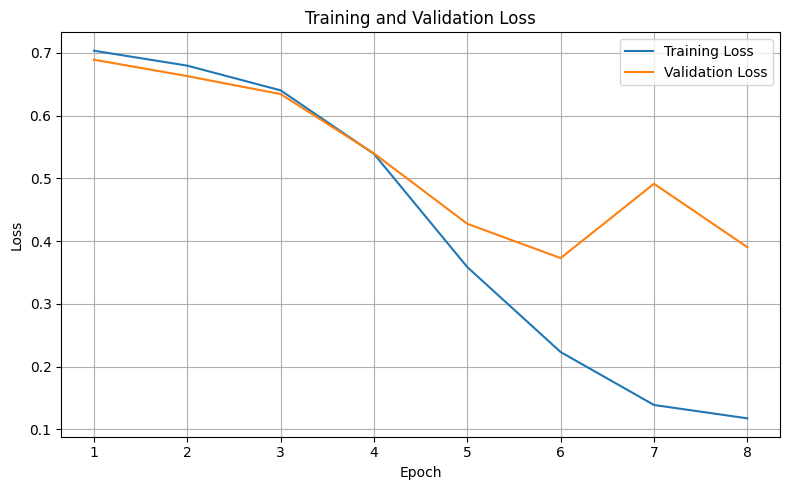

In [67]:
# Visualize loss curves
import matplotlib.pyplot as plt

# Extract training log history
logs = pd.DataFrame(trainer.state.log_history)

# Filter for loss values
loss_logs = logs[logs["loss"].notnull()][["epoch", "loss"]]
eval_logs = logs[logs["eval_loss"].notnull()][["epoch", "eval_loss"]]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(loss_logs["epoch"], loss_logs["loss"], label="Training Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
from pathlib import Path
plt.savefig(Path(results_path) / "loss_curve.png", dpi=300, bbox_inches='tight')

plt.show()

#### 3.2.1 Save last model

In [68]:
# Save the best model and tokenizer
trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

('./best_model\\tokenizer_config.json',
 './best_model\\special_tokens_map.json',
 './best_model\\vocab.txt',
 './best_model\\added_tokens.json',
 './best_model\\tokenizer.json')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [69]:
from sklearn.metrics import classification_report

train_preds = trainer.predict(tokenized_train)
train_preds = np.argmax(train_preds.predictions, axis=1)
GT_train = train_df['label'].tolist()
print("Training Classification Report:")
print(classification_report(GT_train, train_preds))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       255
           1       0.98      0.96      0.97       256

    accuracy                           0.97       511
   macro avg       0.97      0.97      0.97       511
weighted avg       0.97      0.97      0.97       511



#### 3.3.2 Predict test data

In [70]:
# In case you want to change the threshold for classification, you can do so here:
# threshold = 0.5



In [71]:
test_preds = trainer.predict(tokenized_test)
test_preds = np.argmax(test_preds.predictions, axis=1)
GT_test = test_df['label'].tolist()
print("Test Classification Report:")
print(classification_report(GT_test, test_preds))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        71
           1       0.94      0.87      0.91        71

    accuracy                           0.91       142
   macro avg       0.91      0.91      0.91       142
weighted avg       0.91      0.91      0.91       142



In [72]:
# Save test results in 'classification_report.csv'

# Get classification report as a dict
report_dict = classification_report(GT_test, test_preds, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Optionally reset index for nicer format
report_df = report_df.reset_index().rename(columns={"index": "class"})

# Save to CSV if you want
from pathlib import Path
report_df.to_csv(Path(results_path) / "classification_report.csv", index=False)

**Confusion-Matrix for test data:**

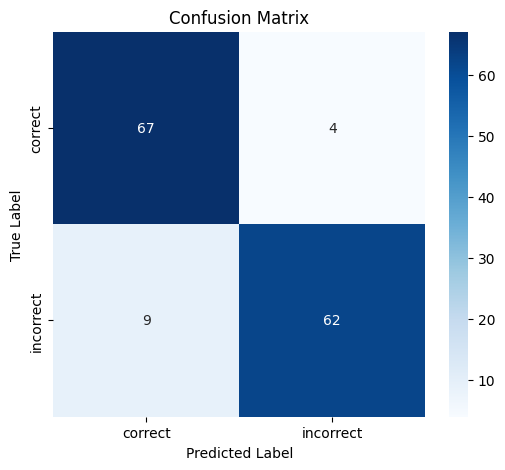

In [73]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT_test, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["correct", "incorrect"],
            yticklabels=["correct", "incorrect"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Save the figure
plt.savefig(Path(results_path) / "confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()

**F1 Score**

In [74]:
from sklearn.metrics import f1_score
print(f"Test F1 score: {f1_score(GT_test, test_preds):.3f}")

Test F1 score: 0.905


#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [75]:
# Get ground truth and predictions for test set
y_true = test_df['label'].tolist()
y_pred = test_preds

# True Positives: predicted 1, actual 1
true_positives = test_df[(test_df['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = test_df[(test_df['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = test_df[(test_df['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = test_df[(test_df['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [76]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 62)


,text
0,"Conversely, valence did not moderate the relat..."
1,This effect did not interact with the order of...
2,"As in Study 2a, identifiability reduced updati..."
3,"Finally, there was no effect of relative heigh..."
4,"For the end-scale questions, there was no diff..."
...,...
57,"In line with our reasoning, results showed no ..."
58,"In the no motivation condition, there was no s..."
59,Tests of the simple effects of target conditio...
60,Time of day did not interact with type of day ...


In [77]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 67)


,text
0,"In this model, the variance of the latent spee..."
1,The most relevant finding for our hypothesis w...
2,"Moreover, using markers of higher-quality list..."
3,"Furthermore, smaller LPP amplitudes were found..."
4,This interaction was driven once again by a si...
...,...
62,The consecutive logistic regression model reve...
63,Adding congruent imagery following the congrue...
64,"Again, the triple interaction (Î² = 0.03, 95% ..."
65,The interaction between congruence and templat...


In [78]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 4)


,text
0,Being in an oppositional climate (vs. the bala...
1,Other individual factors such as age-estimate ...
2,"Specifically, although participants in the con..."
3,"However, no effect of arousal was found for un..."


In [79]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 9)


,text
0,We next focused on report error and found a ma...
1,The results showed a significant two-way inter...
2,These effects were not significantly correlate...
3,"During extinction, the Block (before reinstate..."
4,Follow-up analyses revealed a significant Trea...
5,"In contrast, the mean signed response offset f..."
6,"However, CS type did not interact significantl..."
7,"Most importantly, neither the effect of the st..."
8,A two-way mixed ANOVA investigating whether pe...


## 4 Storing results

### 4.1 Performance over the epochs

In [80]:
# Save log history
log_history = trainer.state.log_history

# Convert to DataFrame
log_df = pd.DataFrame(log_history)

# Save to CSV in 'results_path' folder
log_df.to_csv(Path(results_path) / "model_training_history.csv", index=False)

# Display the first few rows
print(log_df.head())

     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.7036   2.071040       0.000018    1.0    16        NaN            NaN   
1     NaN        NaN            NaN    1.0    16   0.689254       0.526316   
2  0.6798   1.499287       0.000016    2.0    32        NaN            NaN   
3     NaN        NaN            NaN    2.0    32   0.663137       0.631579   
4  0.6404   2.505253       0.000014    3.0    48        NaN            NaN   

   eval_precision  eval_recall   eval_f1  eval_runtime  \
0             NaN          NaN       NaN           NaN   
1        0.510204     0.892857  0.649351        0.5065   
2             NaN          NaN       NaN           NaN   
3        0.684211     0.464286  0.553191        0.5019   
4             NaN          NaN       NaN           NaN   

   eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                      NaN                    NaN            NaN   
1                  112.527                  3.

### 4.2 Final performance on test set

In [81]:
# Save human and BERT labels on test set
predictions_df = pd.DataFrame({
    "statement": test_df['text'],
    "human_label": GT_test,
    "BERT_label": test_preds
})
predictions_df.to_csv(Path(results_path) / "test_predictions.csv", index=False)

In [56]:
# The end...